**Authors:**  Jose Gomez, Max Aragon <br>
**Affiliation:** Department of Geoinformatics, University of Salzburg <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Sentinel-3 Land Surface Temperature</center></h1>

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

* [Download Sentinel 3 Land Surface Temperature](#chapter1)
    * [Create .hdarc file](#section_1_1)
    * [Add queries](#section_1_2)
    * [Download queries](#section_1_3)
    * [Unzip files](#section_1_4)
    
* [Visualize Sentinel-3 Land Surface Temperature](#chapter2)
    * [Sentinel-3 add coordinates](#section_2_1)
    * [Plot whole scene](#section_2_2)
    * [Crop to area of interest, e.g. Salzburg](#section_2_3)
    * [Visualize next to Sentinel-2](#section_2_4)
    * [Generate interactive-hexagon layer](#section_2_5)

## Data access and download <a class="anchor" id="chapter1"></a>  

In [1]:
# Python Standard library
import glob # parse files
import os # os manipulation
import requests # download from the web
import zipfile # unziping

# Plots and colors
import matplotlib.pyplot as plt # plotting
import matplotlib.colors as mcolors # colors from matplotlib
import branca.colormap as cm # colormaps

# Dataframes
import pandas as pd # data frames
import geopandas as gpd # geographical data frames

# Arrays
import numpy as np # array manipulation

# Vectors
from shapely.geometry import Polygon, MultiPolygon # vector manipulations
from h3 import h3 # hexagonal layer

# Rasters
import rasterio # raster manipulation 
import xarray as xr # netcdf manipulations

# Maps
import folium # interactive mapping 

# Data download 
import hda # Wekeo's python Client for HDA 

# 1. Download Sentinel 3 Land Surface Temperature <a class="anchor" id="Section_1_2"></a>

1.1 Create .hdarc file in home directory with your WEkEO credentials

1.2 Add queries to download data (sensors, coordinates, dates, etc)

1.3 Download your queries

1.4 Unzip files 

## 1.1 Create .hdarc file in home directory with your WEkEO credentials

Documentation: https://www.wekeo.eu/docs/harmonised-data-access-api

In [ ]:
# For windows

username = ''
password = ''

userprofile = os.environ['USERPROFILE']
file_string = f'url: https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker \nuser: {username} \npassword: {password}'
file_path = os.path.join(userprofile, '.hdarc')

if os.path.exists(file_path):
    os.remove(file_path)

with open(file_path, 'w') as f:
    f.write(file_string)

In [ ]:
# For linux

username=''
password=''
HOME=os.environ['HOME']
fileString=(f'url: https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker \nuser: {username} \npassword: {password}')
file_path=os.path.join(HOME,'.hdarc')
if os.path.exists(file_path):
    os.remove(file_path)
with open(file_path,'w') as f:
    f.write(fileString)

## 1.2 Add queries to download data (sensors, coordinates, dates, etc)

Find queries here: https://www.wekeo.eu/data

In [2]:
# Example queries for Salzburg


#query 1 downloads Sentinel-3 data in March 2023
query1 = {
  "datasetId": "EO:ESA:DAT:SENTINEL-3:SL_2_LST___",
  "boundingBoxValues": [{"name": "bbox","bbox": [12.920241207974925,47.74980777085517,13.131294440968114,47.893079464931255]}],
  "dateRangeSelectValues": [{"name": "position","start": "2021-11-01T00:00:00.000Z","end": "2022-03-31T00:00:00.000Z"}],
  "stringChoiceValues": [{"name": "productType","value": "SL_2_LST___"}]}

#query 2 downloads Sentinel-3 data in March 2022
query2 = {
  "datasetId": "EO:ESA:DAT:SENTINEL-3:SL_2_LST___",
  "boundingBoxValues": [{"name": "bbox","bbox": [12.920241207974925,47.74980777085517,13.131294440968114,47.893079464931255]}],
  "dateRangeSelectValues": [{"name": "position","start": "2022-11-01T00:00:00.000Z","end": "2023-03-31T00:00:00.000Z"}],
  "stringChoiceValues": [{"name": "productType","value": "SL_2_LST___"},{"name": "processingLevel","value": "2"}]}

# Add queries to a list
queries = [query1, query2]

## 1.3 Download queries

In [ ]:
import os
import zipfile

def download_wekeo(c, queries, dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    existing_files = set(os.listdir(dir_name))
    new_matches = []

    for query in queries:
        matches = c.search(query)
        for match in matches.results:
            filename = match['filename'].split('/')[-1]
            filename_no_ext = filename.replace('.zip', '')
            
            if filename not in existing_files and filename_no_ext not in existing_files:
                match['filename'] = os.path.join(dir_name, filename)
                new_matches.append(match)
            else:
                print(f"{filename} or {filename_no_ext} already exists in the 'data' directory.")

    if new_matches:
        matches.results = new_matches
        matches.download()
        for match in new_matches:
            filepath = match['filename']

c = hda.Client(debug=True)
download_wekeo(c, queries, dir_name='data')

## 1.4 Unzip files

In [9]:
def unzip_files_in_directory(directory):
    for file in os.listdir(directory):
        if file.endswith(".zip"):
            file_path = os.path.join(directory, file)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(directory)
                print(f"Unzipping of product {file} finished.")
            os.remove(file_path)

unzip_files_in_directory('data')

# 2. Visualize Sentinel-3 Land Surface Temperature

2.1 Add coordinates to S3

2.2 Plot whole scene

2.3 Crop to area of interest, e.g. Salzburg

2.4 Visualize next to Sentinel-2

2.5 Generate interactive-hexagon layer

## 2.1 Sentinel-3 add coordinates

In [25]:
import xarray as xr

# Load the LST and geodetic data
lst_data = xr.open_dataset('S3/LST_in.nc')
geodetic_data = xr.open_dataset('S3/geodetic_in.nc')
flags = xr.open_dataset('S3/flags_in.nc')

# Extract the latitude and longitude variables
lat = geodetic_data['latitude_in']
lon = geodetic_data['longitude_in']

clouds = flags['cloud_in']

# Create a 2D grid of coordinates
coords = xr.Dataset(coords={'lat': lat, 'lon': lon})

lst_copy = lst_data.copy(deep=True)

lst_copy = lst_copy.assign_coords(lat=lat, lon=lon);

# Save the modified LST data to a new file
lst_copy.to_netcdf('S3/withLST__coords.nc')

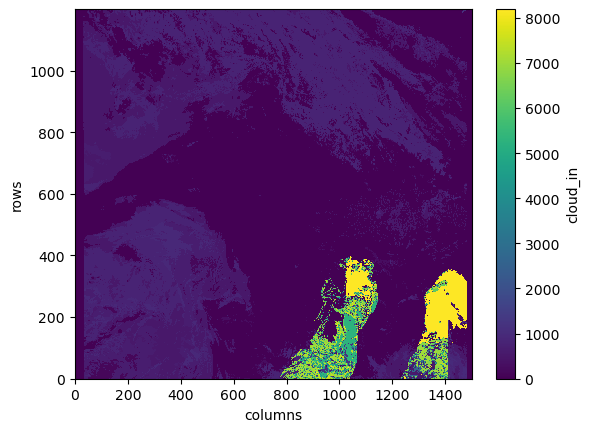

In [30]:
clouds.plot()
plt.show()

## 2.2 Plot whole scene

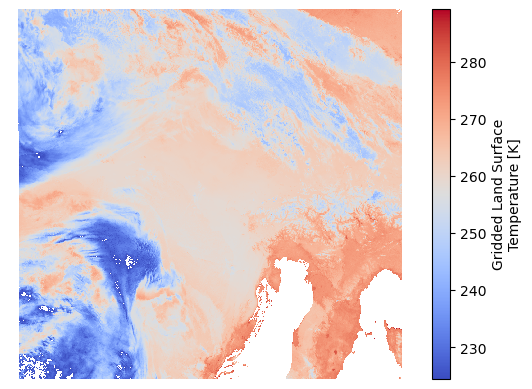

In [199]:
ds_coords = xr.open_dataset('S3/LST_with_coords.nc')
ds_coords.LST.plot(cmap='coolwarm')
plt.axis('off')
plt.show()

## 2.3 Crop to area of interest, e.g. Salzburg

In [15]:
coordinates = [[12.920241207974925, 47.74980777085517], [13.131294440968114, 47.74980777085517], [13.131294440968114, 47.893079464931255], [12.920241207974925, 47.893079464931255]]

west, south = coordinates[0]  # initialize with the first coordinate pair
east, north = coordinates[0]

for lon, lat in coordinates:
    if lon < west:
        west = lon
    elif lon > east:
        east = lon
    if lat < south:
        south = lat
    elif lat > north:
        north = lat

print("Coordinates for Salzburg:")
print("West:", west)
print("South:", south)
print("East:", east)
print("North:", north)

Coordinates for Salzburg:
West: 12.920241207974925
South: 47.74980777085517
East: 13.131294440968114
North: 47.893079464931255


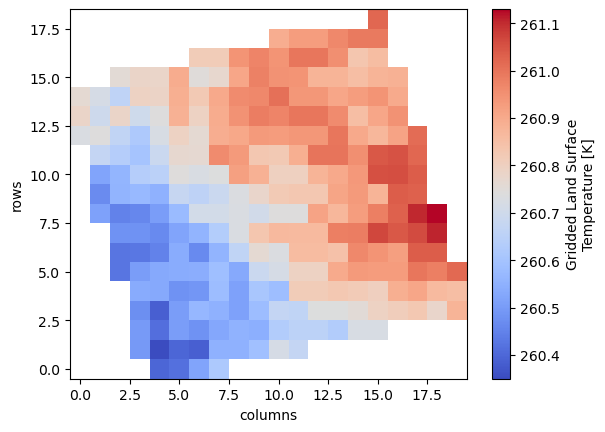

In [236]:
coordinates = [[12.920241207974925, 47.74980777085517],
[13.131294440968114, 47.74980777085517],
[13.131294440968114, 47.893079464931255],
[12.920241207974925, 47.893079464931255]]

aoi_polygon = Polygon(coordinates)

# Crop the data to the AOI
lst_data_crop = lst_data.where((lst_data['lon'] >= aoi_polygon.bounds[0]) &
                               (lst_data['lon'] <= aoi_polygon.bounds[2]) &
                               (lst_data['lat'] >= aoi_polygon.bounds[1]) &
                               (lst_data['lat'] <= aoi_polygon.bounds[3]), drop=True)



lst_data_crop.LST.plot(cmap='coolwarm')
plt.show()

## 2.4 Visualize next to Sentinel-2

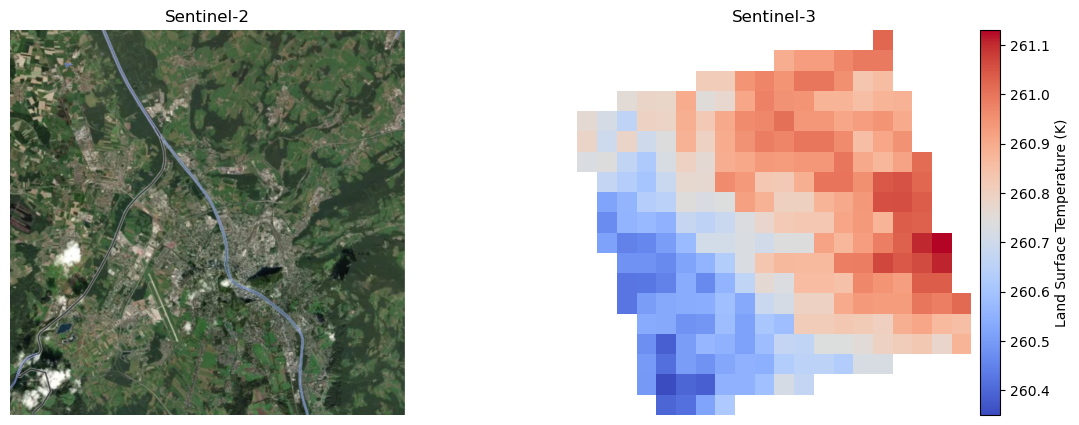

In [333]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot the image and the DataArray
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
im = ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Sentinel-2')
lst_plot = lst_data_crop.LST.plot(ax=ax[1], cmap='coolwarm')
ax[1].axis('off')
ax[1].set_title('Sentinel-3')

# Create a new axis for the colorbar
divider = make_axes_locatable(lst_plot.axes)
cax = divider.append_axes("right", size="5%", pad=0.09)

# Remove the first colorbar
fig.delaxes(lst_plot.colorbar.ax)

# Add the new colorbar
plt.colorbar(lst_plot, cax=cax, label='Land Surface Temperature (K)')

plt.show()

## 2.5 Hexagon layer

In [2]:
# Open the dataset and define the coordinates and AOI polygon
ds_coords = xr.open_dataset('S3/LST_with_coords.nc')



coordinates = [
    [12.920241207974925, 47.74980777085517],
    [13.131294440968114, 47.74980777085517],
    [13.131294440968114, 47.893079464931255],
    [12.920241207974925, 47.893079464931255]
]
aoi_polygon = Polygon(coordinates)


lst_data = ds_coords.LST


# Crop the data to the AOI
lst_data_crop = lst_data.where(
    (lst_data['lon'] >= aoi_polygon.bounds[0]) &
    (lst_data['lon'] <= aoi_polygon.bounds[2]) &
    (lst_data['lat'] >= aoi_polygon.bounds[1]) &
    (lst_data['lat'] <= aoi_polygon.bounds[3]),
    drop=True
)

# Convert the xarray dataset to a pandas DataFrame
df = lst_data_crop.to_dataframe().reset_index()

# Aggregate the data into hexagonal bins
hex_res = 7  # Choose the hexagon resolution
df['hex_id'] = df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lon'], hex_res), axis=1)
hex_df = df.groupby('hex_id').mean().reset_index()

hex_df = hex_df.dropna(subset=['LST'])


# Create a color scale based on the 'LST' values
vmin = hex_df['LST'].min()
vmax = hex_df['LST'].max()

# Generate the colors from the 'plasma' colormap
num_colors = 10
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))

# Convert the colors to hex format
hex_colors = [mcolors.rgb2hex(color) for color in colors]

# Create the color scale
color_scale = cm.LinearColormap(hex_colors, vmin=vmin, vmax=vmax).to_step(num_colors)

sum_lon_bounds = aoi_polygon.bounds[0] + aoi_polygon.bounds[2]


hex_geoms = [MultiPolygon([Polygon([(sum_lon_bounds - coord[1], coord[0]) for coord in ring]) for ring in h3.h3_set_to_multi_polygon([h], geo_json=False)[0]]) for h in hex_df['hex_id']]


hex_gdf = gpd.GeoDataFrame(hex_df, geometry=hex_geoms, crs="EPSG:4326")
hex_geojson = hex_gdf.to_json()



# Create an interactive Leaflet map
m = folium.Map()

# Add the hexagonal bins as a layer
hex_layer = folium.GeoJson(
    hex_geojson,
    tooltip=folium.GeoJsonTooltip(fields=["LST"], aliases=["Value"]),
    style_function=lambda x: {
        "fillColor": color_scale(x['properties']['LST']),
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.8
    },
)

hex_layer.add_to(m)

color_scale.caption = "LST"
m.add_child(color_scale)


# Fit map to the layer bounds
m.fit_bounds(hex_layer.get_bounds())

# Display the map
m